# TITAN_1993

- **Paper**: Thunderstorm Identification Tracking Analysis and Nowcasting

- $\textbf{\textcolor{red}{Identification}}$:
    + **Segmentation**:
        + single threshold
        + contiguous regions with DBz > thresh_dbz & volume > thresh_V
    + **Feature representation**:
        + centroid-based
        + ellipse approximation 
        + params: $x, y$ (for centroid); $r_m, r_r$ (radii), $\theta$ (angle), area

- $\textbf{\textcolor{blue}{Tracking}}$:
    + **Motion estimation**: None
    + **Matching**:
        - *Hungarian matching*:
            + cost = $\|\texttt{center diff}\| + \|\texttt{volume diff}\|$
            + bounded displacement: ~ $\texttt{100 km/h}$
            + output: 1-1 matching storms
        - *Handling split & merge*:
            + split: new storm => check for center overlapping with previous frame
            + merge: expired storm => check for center overlapping with current frame

- $\textbf{\textcolor{yellow}{Nowcasting}}$:
    - **Idea**: forecasting was made separately for each param (centroid, area)
    - **History alignment**:
        + usual case: centroid of previous -> current
        + split: history of child -> copy of par history, translated so that centroid = centroid of child. 
            $$\texttt{Area} = \texttt{par area} * \texttt{ratio of that child over all children}$$
        + merge: history of child -> avg of history of all children with the translation.
            $$\texttt{Area} = \texttt{total area of children}$$
    - Linear regression with exponentially smoothed weights:
        + use the history as the input: $(w_i, (t_i, p_i))$
        + exp smooth: $w_i = 1/2 w_{i+1}$
        + assume: $r_m / r_r$, $\theta$ are fixed 

In [55]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2

## Prepare dataset

In [56]:
from src.preprocessing import read_image, windy_preprocessing_pipeline
from tqdm.notebook import tqdm

data_name = "philippines_13.269_123.832"

SOURCE_PATH = f"data/image_old/{data_name}"

img_paths = [
    os.path.join(SOURCE_PATH, img_name) for img_name in sorted(os.listdir(SOURCE_PATH)) if img_name.endswith('.png')
][:50]

img_shape = read_image(img_paths[0]).shape       # get shape of the image
print(f"Image shape: {img_shape}")
print(f"-" * 20)

dbz_maps = []

for path in tqdm(img_paths, desc="Processing images and detecting storms"):
    img = read_image(path)
    dbz_maps.append(windy_preprocessing_pipeline(img))

print(f"Number of frames: {len(dbz_maps)}")

Image shape: (505, 1220, 3)
--------------------


Processing images and detecting storms:   0%|          | 0/50 [00:00<?, ?it/s]

Number of frames: 50


In [57]:
# from src.preprocessing import read_numpy_grid, nexrad_numpy_preprocessing_pipeline
# from tqdm.notebook import tqdm

# data_name = "KGRR"

# SOURCE_PATH = f"data/numpy_grid/{data_name}"

# img_paths = [
#     os.path.join(SOURCE_PATH, img_name) for img_name in sorted(os.listdir(SOURCE_PATH)) if img_name.endswith('.npy')
# ]

# # img_shape = read_numpy_grid(img_paths[0]).shape       # get shape of the image
# print(f"-" * 20)

# dbz_maps = []

# for path in tqdm(img_paths, desc="Processing images and detecting storms"):
#     img = read_numpy_grid(path)
#     dbz_map = nexrad_numpy_preprocessing_pipeline(img)
#     dbz_maps.append(np.nan_to_num(dbz_map))

# dbz_map_sample = dbz_maps[0]
# img_shape = (dbz_map_sample.shape[0], dbz_map_sample.shape[1], 3)
# print(f"Image shape: {img_shape}")

# print(f"Number of frames: {len(dbz_maps)}")

## 1. Identification

In [58]:
from src.identification import SimpleContourIdentifier, HypothesisIdentifier
from src.preprocessing import convert_contours_to_polygons, convert_polygons_to_contours
from src.cores.base import StormObject, StormsMap
from datetime import datetime
from shapely import Polygon

THRESHOLD = 35
DISTANCE_DBZ = 5
FILTER_AREA = 20        # storm with area under this threshold => cancel
FILTER_CENTER = 10

class CentroidStorm(StormObject):
    centroid: np.ndarray

    def __init__(self, polygon: Polygon, centroid: tuple[float, float], id: str=""):
        super().__init__(contour=polygon, id=id)
        self.centroid = np.array(centroid)
    

Processing images and detecting storms:   0%|          | 0/50 [00:00<?, ?it/s]

--------------------
Time: 2025-01-08 03:10:44 | Detected storms: 6
Time: 2025-01-08 03:16:44 | Detected storms: 5
Time: 2025-01-08 03:22:45 | Detected storms: 7
Time: 2025-01-08 03:28:45 | Detected storms: 11
Time: 2025-01-08 03:34:45 | Detected storms: 9
Time: 2025-01-08 03:40:45 | Detected storms: 12
Time: 2025-01-08 03:46:46 | Detected storms: 14
Time: 2025-01-08 03:52:46 | Detected storms: 10
Time: 2025-01-08 03:58:46 | Detected storms: 10
Time: 2025-01-08 04:04:46 | Detected storms: 10
Time: 2025-01-08 04:10:47 | Detected storms: 9
Time: 2025-01-08 04:16:47 | Detected storms: 8
Time: 2025-01-08 04:22:47 | Detected storms: 16
Time: 2025-01-08 04:28:47 | Detected storms: 12
Time: 2025-01-08 04:34:48 | Detected storms: 13
Time: 2025-01-08 04:40:48 | Detected storms: 8
Time: 2025-01-08 04:46:48 | Detected storms: 6
Time: 2025-01-08 04:52:48 | Detected storms: 14
Time: 2025-01-08 04:58:49 | Detected storms: 13
Time: 2025-01-08 05:04:49 | Detected storms: 12
Time: 2025-01-08 05:10:49 |

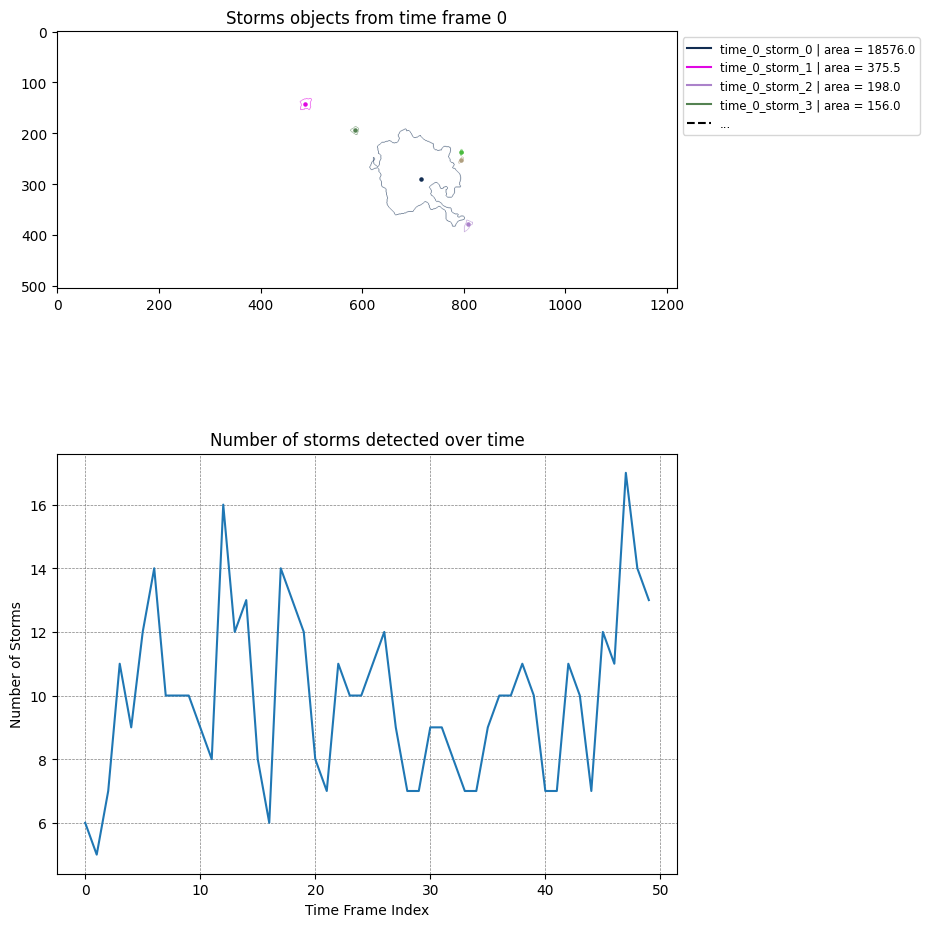

In [59]:
identifier = SimpleContourIdentifier()
# identifier = HypothesisIdentifier(distance_dbz_threshold=DISTANCE_DBZ, filter_center=FILTER_CENTER)
storms_map_time_lst: list[CentroidStorm] = []

for time_idx, (path, dbz_map) in tqdm(enumerate(zip(img_paths, dbz_maps)), total=len(img_paths), desc="Processing images and detecting storms"):
    file_name = path.split("/")[-1].split(".")[0]

    # Convert contours to polygons
    contours = identifier.identify_storm(dbz_map, threshold=THRESHOLD, filter_area=FILTER_AREA)
    polygons = convert_contours_to_polygons(contours)
    polygons = sorted(polygons, key=lambda x: x.area, reverse=True)

    # Construct storms map
    time_frame = datetime.strptime(file_name, "%Y%m%d-%H%M%S")
    # time_frame = datetime.strptime(file_name[4:19], "%Y%m%d_%H%M%S")

    # Keep list of storms
    storms = []

    for idx, polygon in enumerate(polygons):
        contour = convert_polygons_to_contours([polygon])[0]

        # Create the mask of current storm
        mask = np.zeros_like(dbz_map, dtype=np.uint8)
        cv2.fillPoly(mask, contour, color=1)

        # Extract DBZ values inside mask
        weights = dbz_map * mask

        # Create coordinate grids
        y_idx, x_idx = np.indices(dbz_map.shape)

        # Compute weighted centroid
        total_weight = weights.sum()
        if total_weight == 0:
            centroid = (np.nan, np.nan)  # or fallback
        else:
            cx = (x_idx * weights).sum() / total_weight
            cy = (y_idx * weights).sum() / total_weight
            centroid = (int(cx), int(cy))

        storms.append(CentroidStorm(
                polygon, centroid=centroid, id=f"time_{time_idx}_storm_{idx}"
            ))
        
    storms_map = StormsMap(storms, time_frame=time_frame)
    storms_map_time_lst.append(storms_map)

print("-"*20)

# print number of detected storms over time
for storms_map in storms_map_time_lst:
    print(f"Time: {storms_map.time_frame.strftime('%Y-%m-%d %H:%M:%S')} | Detected storms: {len(storms_map.storms)}")

print("-"*20)
# print number of detected storms over time
plt.figure(figsize=(8, 12))

plt.subplot(2,1,1)
blank_image = np.ones(img_shape, dtype=np.uint8) * 255

max_display_storms = 4

for idx, storm in enumerate(storms_map_time_lst[0].storms):
    color = np.random.randint(0, 255, size=3).tolist()
    # x_centroid, y_centroid = storm.contour.centroid.x, storm.contour.centroid.y
    x_centroid, y_centroid = storm.centroid
    
    if idx < max_display_storms:
        plt.plot([], [], color=np.array(color)/255.0, label=f"{storm.id} | area = {storm.contour.area:.1f}")
    elif idx == max_display_storms:
        plt.plot([], [], 'k--', label="...")

    plt.scatter(x_centroid, y_centroid, color=np.array(color)/255.0, s=5)
    cv2.drawContours(blank_image, convert_polygons_to_contours([storm.contour]), -1, color, thickness=1)

plt.legend(bbox_to_anchor=(1, 1), loc="upper left", fontsize='small', ncol=1)
plt.imshow(blank_image,cmap="grey")
plt.title('Storms objects from time frame 0')


plt.subplot(2,1,2)
number_of_storms = [len(storms_map.storms) for storms_map in storms_map_time_lst]
plt.plot(range(len(number_of_storms)), number_of_storms)
plt.title('Number of storms detected over time')
plt.xlabel('Time Frame Index')
plt.ylabel('Number of Storms')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()

## 2. Tracking

### 2.1 Implementation of `Matcher`

- **Idea**: match storms at 2 consecutive times using Hungarian Matching

In [60]:
from src.tracking import BaseMatcher, BaseTrackingHistory

class SimpleMatcher(BaseMatcher):
    max_velocity: float     # unit: pixel/hr

    def __init__(self, max_velocity: float):
        self.max_velocity = max_velocity

    def _construct_disparity_matrix(
            self, storm_lst1: list[CentroidStorm], storm_lst2: list[CentroidStorm]
        ) -> tuple[np.ndarray, np.ndarray]:
        # get square root of area difference
        area_lst1 = np.array([storm.contour.area for storm in storm_lst1])
        area_lst2 = np.array([storm.contour.area for storm in storm_lst2])
        area_matrix = np.sqrt(np.abs(area_lst1[:, None] - area_lst2[None, :]))

        # get centroid displacement
        centroid_lst1 = np.array([storm.centroid for storm in storm_lst1])
        centroid_lst2 = np.array([storm.centroid for storm in storm_lst2])
        centroid_displacement_matrix = np.linalg.norm(centroid_lst1[:,None,:] - centroid_lst2[None,:,:], axis=2)
        
        return area_matrix + centroid_displacement_matrix, centroid_displacement_matrix
    
    def match_storms(
            self, storm_map1: StormsMap, storm_map2: StormsMap
        ) -> np.ndarray:
        """
        Match storms between 2 time frame.

        Args:
            storm_map1 (StormsMap): storm map in the 1st frame.
            storm_map2 (StormsMap): storm map in the 2nd frame.
        
        Returns:
            assignments (np.ndarray): Array of (prev_idx, curr_idx) pairs representing matched storms.
        """
        dt = (storm_map2.time_frame - storm_map1.time_frame).seconds / 3600     # unit: hr
        max_displacement = dt * self.max_velocity

        cost_matrix, displacement_matrix = self._construct_disparity_matrix(storm_map1.storms, storm_map2.storms)
        invalid_mask = displacement_matrix > max_displacement

        cost_matrix = cost_matrix + invalid_mask.astype(np.float64) * 2000      # add penalty to those violated
        row_ind, col_ind = self._hungarian_matching(cost_matrix)

        assignment_mask = np.zeros_like(invalid_mask, dtype=bool)
        assignment_mask[row_ind, col_ind] = True

        return np.argwhere(assignment_mask & np.logical_not(invalid_mask))

In [61]:
matcher = SimpleMatcher(max_velocity=50)
assignments = matcher.match_storms(storms_map_time_lst[0], storms_map_time_lst[1])

assignments

array([[1, 1],
       [4, 3],
       [5, 4]])

### 2.2 Implementation of `TrackingHistory`

- **Idea**: keep track of storms evolution over time.

- **Public methods**:
    - $\textcolor{yellow}{\text{forecast}}$: forecast the next position of current storm track.
    - $\textcolor{yellow}{\text{update}}$: receive the mapping of current storms and update the track.

In [62]:
from dataclasses import dataclass, field
from copy import deepcopy

@dataclass
class StormRecord:
    """
    Record: is a part of `StormTrack`, contains information about a storm at a specific time frame.
    """
    track_id: int
    storm: CentroidStorm
    time_frame: datetime
    is_virtual: bool = field(default=False)      # if virtual: the current storm of the corresponding track is splitted and this storm is created to keep track of the splitted part.
    parent_track_id: int = field(default=None)   # if virtual: the id of the parent track from which this storm is splitted.

@dataclass
class StormTrack:
    """
    Track: contains the history of a storm over time frames.
    """
    id: int
    records: list[StormRecord] = field(default_factory=list)
    movements: list[np.ndarray] = field(default_factory=list)   # list of movement vectors over time
    active: bool = field(default=True)                          # whether the track is still active or not
    merged: bool = field(default=False)                         # in case the track is inactive, check whether the track has been merged into another track
    merged_to: int = field(default=None)                        # if merged, the id of the track to which this track is merged

    def add_record(self, record: StormRecord, motion_vector: np.ndarray = None):
        self.records.append(record)
        if motion_vector is not None:
            self.movements.append(motion_vector)
    
    def get_latest_record(self) -> StormRecord:
        return self.records[-1] if self.records else None
    
    def get_copy(self, new_id: int, last_time: datetime) -> "StormTrack":
        """
        Return a copy of the current track with a new id.
        """
        new_track = StormTrack(id=new_id)
        new_track.records = deepcopy(self.records)
        for record in new_track.records:
            record.track_id = new_id
            record.is_virtual = True
            record.parent_track_id = self.id

        for movement in self.movements:
            new_track.movements.append(deepcopy(movement))

        if len(new_track.records) > 0 and new_track.records[-1].time_frame >= last_time:
            # drop the last record if it exceeds the last time
            new_track.records.pop()
            if len(new_track.movements) > 0:
                new_track.movements.pop()

        return new_track


In [63]:
from copy import deepcopy
from shapely import Polygon
from shapely.affinity import translate

class TrackingHistory(BaseTrackingHistory):
    tracks: list[StormTrack] = []
    storm_dict: dict[str, int] = {}      # mapping from storm id to track id
    active_list: list[int] = []          # list of active track ids

    def __init__(self, storms_map: StormsMap):
        self.tracks = []
        for storm in storms_map.storms:
            self.tracks.append(self._initialize_track(storm, storms_map.time_frame))

        self.storm_dict = {storm.id: idx for idx, storm in enumerate(storms_map.storms)}
        self.active_list = list(range(len(self.storm_dict)))
    
    def _initialize_track(self, storm: CentroidStorm, time_frame: datetime):
        new_id = len(self.tracks)
        return StormTrack(
            id=new_id,
            records=[StormRecord(
                track_id=new_id,
                storm=storm,
                time_frame=time_frame
            )]
        )
    
    def _get_track(self, storm_id: str) -> StormTrack:
        """
        Get the track of storm with storm_id, if there is no track found, raise `KeyError`.

        Args:
            storm_id (str): id of the storm
        
        Returns:
            track, is_active (tuple(dict, float))
        """
        if storm_id not in self.storm_dict:
            raise KeyError(f"Storm not found in the current track.")
        track_id = self.storm_dict[storm_id]
        return self.tracks[track_id]
    
    def _interpolate_velocity(self, velocity_lst: list[np.ndarray], alpha_decay: float = 0.5):
        if len(velocity_lst) == 1:
            return velocity_lst[0]
        
        weights = np.array([alpha_decay**i for i in range(len(velocity_lst))])
        total_w = np.sum(weights)
        return np.sum([displ * w / total_w for displ, w in zip(velocity_lst[::-1], weights)], axis=0)

    def forecast(self, storm_id: str, dt: float, default_motion: np.ndarray = np.array([0,0])) -> CentroidStorm:
        """
        Make a forecast for the next position of the track with track_id using the history.
        
        Args:
            storm_id (int): id of the storm.
            dt (float): the interval between the current and next frame.
            default_motion (np.ndarray, default): default motion used in case there is no recorded history.
        
        Returns:
            storm (CentroidStorm): the estimated storm in the next frame.
        """
        track = self._get_track(storm_id)
        if not track.active:
            print(f"⚠️ Storm has been expired")
            
        curr_storm = track.records[-1].storm

        velocity_lst = track.movements
        if len(velocity_lst) == 0:          # if no recorded velocity => use the default motion.
            velocity_lst = [default_motion]
        
        dx, dy = self._interpolate_velocity(velocity_lst) * dt
        new_pol = translate(curr_storm.contour, xoff=dx, yoff=dy)
        new_centroid = curr_storm.centroid + np.array(dx, dy)

        return CentroidStorm(new_pol, centroid=new_centroid)

    def _handle_merge(self, merge_lst: list[dict]) -> np.ndarray:
        """
        Combine the list of storms to generate the parent storm history.
        
        Args:
            merge_lst (list[dict]): contains information about the storm, including movement history, area.
        """
        weights = np.array([s["area"] for s in merge_lst])
        movements_lst = [np.array(s["movement"])[::-1] for s in merge_lst]  # revert for matching the time.

        combined_len = max([len(movements) for movements in movements_lst]) # length of parent = max length of its child
        parent_movement = np.zeros(shape=(combined_len, 2), dtype=np.float64)

        for i in range(combined_len):
            total_value, total_weight = np.zeros(shape=(2,)), 0
            for weight, movements in zip(weights, movements_lst):
                if len(movements) <= i:
                    continue
                total_value += movements[i]
                total_weight += weight
            parent_movement[i] = total_value / total_weight
        
        return parent_movement[::-1]

    def update(
            self, prev_mapping: dict, curr_mapping: dict, prev_storms_map: StormsMap, curr_storms_map: StormsMap,
        ):
        """
        Update the tracking history using the new mapping data.

        Args:
            prev_mapping (dict): key -> idx of prev storm; items -> list[idx of curr storm].
            curr_mapping (dict): key -> idx of curr storm; items -> list[idx of prev storm].
            time_frame (datetime): time of current mapping.
        """
        active_lst = []         # update the new active list
        curr_time = curr_storms_map.time_frame
        prev_time = prev_storms_map.time_frame

        dt = (curr_time - prev_time).seconds / 3600

        def get_movement(prev_idx, curr_idx):
            """
            Get the centroid movement of 2 storms, scaled to pixel/hr.
            """
            return (curr_storms_map.storms[curr_idx].centroid - prev_storms_map.storms[prev_idx].centroid) / dt

        for curr_idx, matched in curr_mapping.items():
            curr_storm = curr_storms_map.storms[curr_idx]

            ## Case 1: no previous matching => create the new track.
            if len(matched) == 0:
                # create new track
                self.tracks.append(self._initialize_track(curr_storm, curr_time))

                # update storm dict and active_lst
                new_tid = len(self.tracks) - 1
                self.storm_dict[curr_storm.id] = new_tid
                active_lst.append(new_tid)

            ## Case 2: more than 1 parent storms => merged
            elif len(matched) > 1:
                merge_lst = []
                max_score = 0
                longest_history = 0
                track_id = None

                for prev_idx in matched:
                    prev_storm = prev_storms_map.storms[prev_idx]   # get the previous storm

                    track = self._get_track(prev_storm.id)          # get the corresponding track
                    area = prev_storm.contour.area
                    if area > max_score and longest_history <= len(track.records):
                        max_score = area
                        longest_history = len(track.records)
                        track_id = self.storm_dict[prev_storm.id]   # track with highest area & longest history will be extended, others are terminated
                    
                    merge_lst.append({
                        "area": prev_storm.contour.area,
                        "movement": track.movements + [get_movement(prev_idx, curr_idx)]
                    })
                
                current_track: StormTrack = self.tracks[track_id]
                
                movement_history = self._handle_merge(merge_lst)    # resolve the history
                current_track.add_record(StormRecord(
                    track_id=track_id,
                    storm=curr_storm,
                    time_frame=curr_time
                ), None)
                current_track.movements = list(movement_history)    # update the movement history

                # update storm dict & active lst
                active_lst.append(track_id)
                self.storm_dict[curr_storm.id] = track_id
            
            ## Case 3: only 1 parent storm
            else:
                prev_idx = matched[0]
                prev_storm = prev_storms_map.storms[prev_idx]   # get the previous storm

                # case 3.1: parent has more than 2 childrens => split
                #   => movement = combined centroid - previous storm centroid
                if len(prev_mapping[prev_idx]) > 1:
                    # get the combined centroid using area as weight.
                    weight_centroids = [(curr_storms_map.storms[j].centroid, curr_storms_map.storms[j].contour.area) \
                                          for j in prev_mapping[prev_idx]]
                    total_w = np.sum([w for _, w in weight_centroids])
                    combined_centroid = np.sum([centroid * w / total_w for centroid, w in weight_centroids], axis=0)

                    # get the movement from parent -> combined centroid
                    movement = (combined_centroid - prev_storm.centroid) / dt

                    # copy the previous track into the new, then update parameters.
                    new_track = self._get_track(prev_storm.id).get_copy(new_id=len(self.tracks), last_time=curr_time)
                    # new_track = deepcopy(self._get_track(prev_storm.id))
                    self.tracks.append(new_track)
                    new_track.add_record(
                        StormRecord(
                            track_id=new_track.id,
                            storm=curr_storm,
                            time_frame=curr_time), 
                        motion_vector=movement
                    )

                    new_tid = len(self.tracks) - 1
                    self.storm_dict[curr_storm.id] = new_tid
                    active_lst.append(new_tid)

                # case 3.2: one-to-one parent-child
                else:
                    # update the current track
                    movement = get_movement(prev_idx, curr_idx)
                    current_track = self._get_track(prev_storm.id)
                    current_track.add_record(
                        record=StormRecord(
                            track_id=current_track.id,
                            storm=curr_storm,
                            time_frame=curr_time
                    ), motion_vector=movement)

                    track_id = self.storm_dict[prev_storm.id]
                    self.storm_dict[curr_storm.id] = track_id
                    active_lst.append(track_id)
        
        for track_id in self.active_list:
            if track_id not in active_lst:
                self.tracks[track_id].active = False
                
        self.active_list = sorted(active_lst)

    def print_tracks(self):
        for id, track in enumerate(self.tracks):
            print(f"Track {id:2d}. " + " -> ".join(record.storm.id for record in track.records))
            print(f"Status: {'ACTIVE' if track.active else 'EXPIRED'}")
            print(f"Lifespan: {len(track.records)}")
            print(f"Last track: {track.records[-1].time_frame.strftime('%Y-%m-%d %H:%M:%S')}")
            print(f"-" * 50)

### 2.3 Implementation of `Tracker`

- **Idea**: a common class that keep everything about the tracking step.

- **Methods**:
    - $\textcolor{yellow}{\text{fit}}$: receive the list of storms over time, match them step-by-step and record the tracking history.
    - $\textcolor{yellow}{\text{predict}}$: predict the next position of the current track.

In [64]:
from shapely import Point
from src.cores.metrics import pod_score, far_score, csi_score
from src.tracking import BaseTracker

class SimpleTracker(BaseTracker):
    matcher: SimpleMatcher
    tracker: TrackingHistory

    def __init__(self, max_velocity: float):
        self.matcher = SimpleMatcher(max_velocity)
        
    def fit(self, storms_map_time_lst: list[StormsMap], test=False):
        self.tracker = TrackingHistory(storms_map_time_lst[0])
        csi_scores, far_scores, pod_scores, frames = [], [], [], []

        for idx in range(0, len(storms_map_time_lst)-1):
            # get the current maps
            prev_storms_map, curr_storms_map = storms_map_time_lst[idx], storms_map_time_lst[idx+1]
            dt = (curr_storms_map.time_frame - prev_storms_map.time_frame).seconds / 3600   # scaled to hour

            # match using Hungarian algorithm
            assignments = self.matcher.match_storms(prev_storms_map, curr_storms_map)

            # resolve merge & split
            ## mapping: dict where key -> index of storm; value -> list of tuple[storm_id]
            mapping_prev = {int(prev_idx): [int(curr_idx)] \
                                for prev_idx, curr_idx in assignments}  # , displacements[prev_idx][curr_idx]
            mapping_curr = {int(curr_idx): [int(prev_idx)] \
                                for prev_idx, curr_idx in assignments}

            prev_assigned, curr_assigned = mapping_prev.keys(), mapping_curr.keys()
            prev_unassigned = [idx for idx in range(len(prev_storms_map.storms)) if idx not in prev_assigned]
            curr_unassigned = [idx for idx in range(len(curr_storms_map.storms)) if idx not in curr_assigned]


            if len(prev_unassigned) > 0 or len(curr_unassigned) > 0:  # if any unassigned => resolve
                pred_storms_map = StormsMap([
                        self.tracker.forecast(storm.id, dt)
                        for storm in prev_storms_map.storms
                    ], time_frame=curr_storms_map.time_frame)

                # Check for merging
                for prev_idx in prev_unassigned:
                    pred_storm = pred_storms_map.storms[prev_idx]

                    # Find storms that the predicted centroid fall into.
                    candidates = [
                            idx for idx, storm in enumerate(curr_storms_map.storms) \
                                if storm.contour.contains(Point(pred_storm.centroid))
                        ]
                    
                    if len(candidates) == 0:
                        mapping_prev[prev_idx] = []
                        continue
                    
                    child_storm_idx = candidates[0]

                    # Case: more than 1 candidates => choose one with maximum overlapping on prev_storm
                    if len(candidates) > 1:
                        def compute_overlapping(curr_idx):
                            return pred_storm.contour.intersection(curr_storms_map.storms[curr_idx].contour).area / pred_storm.contour.area
                        
                        child_storm_idx = max(candidates, key=compute_overlapping)
                    
                    # update mapping_prev & mapping_curr
                    mapping_prev[prev_idx] = [child_storm_idx]

                    if child_storm_idx not in mapping_curr:
                        mapping_curr[child_storm_idx] = []

                    mapping_curr[child_storm_idx].append(prev_idx)
                
                # Check for splitting
                for curr_idx in curr_unassigned:
                    curr_storm = curr_storms_map.storms[curr_idx]
                    # Find predicted storms that the current centroid fall into.
                    candidates = [
                            idx for idx, storm in enumerate(pred_storms_map.storms) \
                                if storm.contour.contains(Point(curr_storm.centroid))
                        ]
                    
                    if len(candidates) == 0:
                        mapping_curr[curr_idx] = []
                        continue

                    parent_storm_idx = candidates[0]

                    # Case: more than 1 candidates => only choose one with maximum overlapping on prev_storm
                    if len(candidates) > 1:
                        def compute_overlapping(i):
                            return curr_storm.contour.intersection(pred_storms_map.storms[i].contour).area / curr_storm.contour.area
                        
                        parent_storm_idx = max(candidates, key=compute_overlapping)

                    # update mapping_prev & mapping_curr
                    mapping_curr[curr_idx] = [parent_storm_idx]

                    if parent_storm_idx not in mapping_prev:
                        mapping_prev[parent_storm_idx] = []

                    mapping_prev[parent_storm_idx].append(curr_idx)             
            
            if test:
                pred_storms_map = StormsMap([
                        self.tracker.forecast(storm.id, dt)
                        for storm in prev_storms_map.storms
                    ], time_frame=curr_storms_map.time_frame)
                csi_scores.append(csi_score(pred_storms_map, curr_storms_map))
                far_scores.append(far_score(pred_storms_map, curr_storms_map))
                pod_scores.append(pod_score(pred_storms_map, curr_storms_map))
                frames.append(curr_storms_map.time_frame)

            self.tracker.update(mapping_prev, mapping_curr, prev_storms_map, curr_storms_map)
        
        if test:
            return csi_scores, far_scores, pod_scores, frames
    
    def predict(self, storm: CentroidStorm, dt: float):
        try:
            return self.tracker.forecast(storm.id, dt)
        except KeyError:
            print(f"❗ Storm not found on the track. `None` will be returned.")
            return None

In [65]:
MAX_VELOCITY = 50  # unit: pixel/hr

tracker = SimpleTracker(max_velocity=MAX_VELOCITY)
csi_scores, far_scores, pod_scores, frames = tracker.fit(storms_map_time_lst, test=True)

tracker.tracker.print_tracks()

Track  0. time_0_storm_0
Status: EXPIRED
Lifespan: 1
Last track: 2025-01-08 03:10:44
--------------------------------------------------
Track  1. time_0_storm_1 -> time_1_storm_1 -> time_2_storm_2 -> time_3_storm_2 -> time_4_storm_3 -> time_5_storm_3 -> time_6_storm_3 -> time_7_storm_6 -> time_8_storm_6 -> time_9_storm_6
Status: EXPIRED
Lifespan: 10
Last track: 2025-01-08 04:04:46
--------------------------------------------------
Track  2. time_0_storm_2
Status: EXPIRED
Lifespan: 1
Last track: 2025-01-08 03:10:44
--------------------------------------------------
Track  3. time_0_storm_3
Status: EXPIRED
Lifespan: 1
Last track: 2025-01-08 03:10:44
--------------------------------------------------
Track  4. time_0_storm_4 -> time_1_storm_3
Status: EXPIRED
Lifespan: 2
Last track: 2025-01-08 03:16:44
--------------------------------------------------
Track  5. time_0_storm_5 -> time_1_storm_4
Status: EXPIRED
Lifespan: 2
Last track: 2025-01-08 03:16:44
------------------------------------

## 3. Nowcasting

In [66]:
from src.cores.metrics import pod_score, far_score, csi_score

bm_pod_scores = []
bm_far_scores = []
bm_csi_scores = []

print("Naive nowcasting prediction: Only using the last map without any motion update")
print("Results:")
for idx in range(len(storms_map_time_lst)-1):
    prev_storm = storms_map_time_lst[idx]
    curr_storm = storms_map_time_lst[idx+1]
    bm_pod_scores.append(pod_score(prev_storm, curr_storm))
    bm_far_scores.append(far_score(prev_storm, curr_storm))
    bm_csi_scores.append(csi_score(prev_storm, curr_storm))
    print(f"\tTime {curr_storm.time_frame.strftime('%Y-%m-%d %H:%M:%S')} | POD: {pod_score(prev_storm, curr_storm):.4f} | FAR: {far_score(prev_storm, curr_storm):.4f} | CSI: {csi_score(prev_storm, curr_storm):.4f}")

indexes = range(len(bm_pod_scores))
scores = [bm_pod_scores, bm_far_scores, bm_csi_scores]
titles = ['Probability of Detection Over Time', 'False Alarm Rate Over Time', 'Critical Success Index Over Time']

Naive nowcasting prediction: Only using the last map without any motion update
Results:
	Time 2025-01-08 03:16:44 | POD: 0.9424 | FAR: 0.0831 | CSI: 0.8683
	Time 2025-01-08 03:22:45 | POD: 0.8285 | FAR: 0.5211 | CSI: 0.4357
	Time 2025-01-08 03:28:45 | POD: 0.8986 | FAR: 0.1521 | CSI: 0.7739
	Time 2025-01-08 03:34:45 | POD: 0.8945 | FAR: 0.1646 | CSI: 0.7605
	Time 2025-01-08 03:40:45 | POD: 0.6881 | FAR: 0.4947 | CSI: 0.4111
	Time 2025-01-08 03:46:46 | POD: 0.8744 | FAR: 0.1409 | CSI: 0.7648
	Time 2025-01-08 03:52:46 | POD: 0.4498 | FAR: 0.5685 | CSI: 0.2824
	Time 2025-01-08 03:58:46 | POD: 0.8317 | FAR: 0.2298 | CSI: 0.6663
	Time 2025-01-08 04:04:46 | POD: 0.8060 | FAR: 0.1808 | CSI: 0.6842
	Time 2025-01-08 04:10:47 | POD: 0.7158 | FAR: 0.3455 | CSI: 0.5195
	Time 2025-01-08 04:16:47 | POD: 0.8580 | FAR: 0.1429 | CSI: 0.7506
	Time 2025-01-08 04:22:47 | POD: 0.4297 | FAR: 0.6329 | CSI: 0.2468
	Time 2025-01-08 04:28:47 | POD: 0.7437 | FAR: 0.3793 | CSI: 0.5113
	Time 2025-01-08 04:34:48 | 

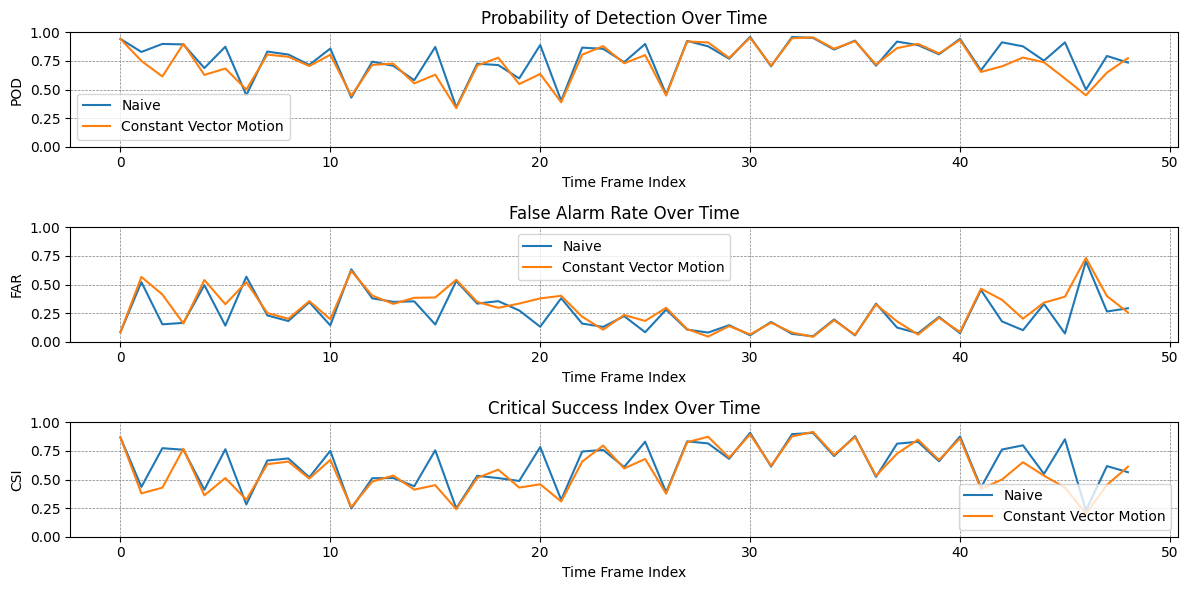

In [67]:
indexes = range(len(bm_pod_scores))
scores = [
    (bm_pod_scores, pod_scores), 
    (bm_far_scores, far_scores),
    (bm_csi_scores, csi_scores)
]
titles = ['Probability of Detection Over Time', 'False Alarm Rate Over Time', 'Critical Success Index Over Time']
ylabels = ['POD', 'FAR', 'CSI']

plt.figure(figsize=(12, 6))

for i, title in enumerate(titles):
    plt.subplot(3, 1, i+1)
    plt.plot(indexes, scores[i][0], label='Naive')
    plt.plot(indexes, scores[i][1], label='Constant Vector Motion')
    plt.title(title)
    plt.xlabel('Time Frame Index')
    plt.ylabel(ylabels[i])
    plt.ylim(0, 1)
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    plt.legend()

plt.tight_layout()
plt.show()

## 4. Forecasting evaluation

In [68]:
train_idx = 20
test_idx = 27

prev_storms_map = storms_map_time_lst[train_idx-1]
curr_storms_map = storms_map_time_lst[test_idx]

dt = (storms_map_time_lst[test_idx].time_frame - storms_map_time_lst[train_idx].time_frame).seconds / 3600.0
print(f"Overhead time: {dt * 60:.2f} minutes")

tracker = SimpleTracker(max_velocity=MAX_VELOCITY)
tracker.fit(storms_map_time_lst[:train_idx], test=False)

pred_storms_map = StormsMap([
        tracker.tracker.forecast(storm.id, dt)
        for storm in prev_storms_map.storms
    ], time_frame=curr_storms_map.time_frame)

print(f"POD score: {pod_score(pred_storms_map, curr_storms_map):.4f}")
print(f"CSI score: {csi_score(pred_storms_map, curr_storms_map):.4f}")
print(f"FAR score: {far_score(pred_storms_map, curr_storms_map):.4f}")

Overhead time: 42.03 minutes
POD score: 0.1401
CSI score: 0.1180
FAR score: 0.5718


In [69]:
import pandas as pd

def forecast_evaluation(lead_time: int, train_len: int = 10):
    pod_scores = []
    csi_scores = []
    far_scores = []
    leading_times = []

    time_list = range(train_len, len(storms_map_time_lst)-lead_time)

    MAX_VELOCITY = 50  # unit: pixel/hr
    time_list = range(train_len, len(storms_map_time_lst)-lead_time)

    for train_idx in tqdm(time_list, total=len(time_list)):
        test_idx = train_idx + lead_time

        prev_storms_map = storms_map_time_lst[train_idx-1]
        curr_storms_map = storms_map_time_lst[test_idx]

        dt = (curr_storms_map.time_frame - prev_storms_map.time_frame).seconds / 3600.0

        tracker = SimpleTracker(max_velocity=MAX_VELOCITY)
        tracker.fit(storms_map_time_lst[train_idx-train_len:train_idx], test=False)

        pred_storms_map = StormsMap([
                tracker.tracker.forecast(storm.id, dt)
                for storm in prev_storms_map.storms
            ], time_frame=curr_storms_map.time_frame)
        
        pod = pod_score(pred_storms_map, curr_storms_map)
        csi = csi_score(pred_storms_map, curr_storms_map)
        far = far_score(pred_storms_map, curr_storms_map)

        pod_scores.append(pod)
        csi_scores.append(csi)
        far_scores.append(far)
        leading_times.append(dt * 60)   # convert to minutes

    forecast_leads_df = pd.DataFrame({
        'predict_time': [storms_map_time_lst[i+lead_time].time_frame for i in time_list],
        'POD': pod_scores,
        'FAR': far_scores,
        'CSI': csi_scores,
        'leading_time (min)': leading_times
    })

    output_dir = f'output/{data_name}/{lead_time}_frame_leads'
    os.makedirs(output_dir, exist_ok=True)

    forecast_leads_df.to_csv(f'{output_dir}/TITAN.csv', index=False)
    print(f"Store file successfully at {output_dir}/TITAN.csv")

### 4.1 3-frame leads

In [70]:
forecast_leads_df = forecast_evaluation(lead_time=3, train_len=10)

forecast_leads_df

  0%|          | 0/37 [00:00<?, ?it/s]

Store file successfully at output/philippines_13.269_123.832/3_frame_leads/TITAN.csv


### 4.1 5-frame leads

In [71]:
forecast_leads_df = forecast_evaluation(lead_time=5, train_len=10)

forecast_leads_df

  0%|          | 0/35 [00:00<?, ?it/s]

Store file successfully at output/philippines_13.269_123.832/5_frame_leads/TITAN.csv
